# Data Preprocessing

In [2]:
import pandas as pd
import numpy as np
import csv
import copy
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import csv
import copy
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans, AffinityPropagation, AgglomerativeClustering, DBSCAN
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.preprocessing import normalize
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler, scale
from matplotlib.collections import LineCollection
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
import matplotlib.cm as cm

random_state = 32

def preprocess(filepath):
    df = pd.read_csv(filepath)
    attributes = df.columns
    nominalvalues = {}

    df = df.replace('N/A', np.NaN)
    # df = df.replace('?', np.NaN)
    for col in df.columns:
        # deal with the $ and ,
        if df[col].dtype == "object":
            df[col] = df[col].str.replace("$", "")
            df[col] = df[col].str.replace(",", "")
            try:
                df[col] = df[col].astype(float)
            except ValueError:
                print("%r is string." %col)
        # deal with missing values
        if sum(pd.isnull(df[col])) != 0 or sum(df[col].isin(["?"])) > 0:
            print(filepath)
            print("%r column (type: %r): %r null" %(col, df[col].dtype, sum(pd.isnull(df[col]))))
            if df[col].dtype == "object":
                md = df[df[col] != np.NaN][col].mode()[0]
                df[col] = df[col].replace(np.NaN, md)

            else:
                mn = df[col].astype(float).mean()
                df[col] = df[col].replace(np.NaN, mn)
        if df[col].dtype == "object":
            nominalvalues[col] = df[col].unique().tolist()
            df[col] = df[col].astype(str)

    # generate arff file
    with open(filepath+".arff", "w") as f:
        f.write("@relation %r\n\n" %filepath)
        for attr in attributes:
            if attr in nominalvalues.keys():
                nv = "\",\"".join(nominalvalues[attr])
                nv = "\"" + nv + "\""
                f.write("@attribute " + attr.replace(" ", "_") + " {" + nv +"}\n")
            else:
                f.write("@attribute " + attr.replace(" ", "_") + " numeric\n")
        f.write("\n")
        f.write("@data\n")
        df.to_csv(filepath+".csv", header=False, index=False, quoting=csv.QUOTE_NONNUMERIC)
        with open(filepath+".csv") as nf:
            for line in nf:
                f.write(line)
    f.close()
    nf.close()

    return df, nominalvalues

def calsse(df, clusters, centroid):
    df = pd.DataFrame(df)
    total = 0
    count = 0
    for i in range(len(clusters)):
        for p in clusters[i]:
            count+=1
            total += distance(df.iloc[p, :], centroid[i])
    # print(count)
    return total

def distance(inst1, inst2):
    try:
        inst1 = np.array(inst1)
        inst2 = np.array(inst2)

        if len(inst1) != len(inst2):
            raise NameError("Not the same dimension.")

        total = 0
        for i in range(len(inst1)):
            total += (inst1[i] - inst2[i])**2
        return total
    except ValueError:
        return 100

def digdtpb(df, k, nor=False):
    if nor == True:
        ndtpb = df.iloc[:, 1:]
        dfcol = ndtpb.columns
        ndtpb = scale(df.iloc[:, 1:])
    else:
        ndtpb = df.iloc[:, 1:]
        dfcol = ndtpb.columns
    y = df.iloc[:, -1]

    kmeans = None
    minsse = None

    for i in range(1):
        tkmeans = KMeans(n_clusters=k, random_state=32)
        y_pred = tkmeans.fit_predict(ndtpb)
        # clusters = dict.fromkeys([i for i in range(k)],[])
        sse = tkmeans.inertia_
        # print(sse)
        if minsse is None:
            kmeans = copy.deepcopy(tkmeans)
            minsse = sse
        else:
            if sse < minsse:
                kmeans = copy.deepcopy(tkmeans)
                minsse = sse

    # kmeans = KMeans(n_clusters=k, random_state=random_state)
    y_pred = kmeans.fit_predict(ndtpb)
    # clusters = dict.fromkeys([i for i in range(k)],[])
    clusters = dict.fromkeys([i for i in range(k)], None)
    for i in range(len(clusters)):
        clusters[i] = []
    # print("%r rows" %len(y_pred))
    for label in range(len(y_pred)):
        clusters[y_pred[label]].append(label)
    print("k=%r, %r" %(k, calsse(ndtpb, clusters, kmeans.cluster_centers_)))
    sse = calsse(ndtpb, clusters, kmeans.cluster_centers_)

    major = {}
    for i in range(k):
        major[i] = [df.iloc[m, 0] for m in clusters.get(i)]
    for d in range(len(major)):
        print("Cluster %r: %r" %(d, ", ".join(major[d])))
        print(kmeans.cluster_centers_[d])
    # df_clusters = pd.DataFrame([i for i in range(k)], columns=["K"])
    return major, y_pred

def acdigdtpb(df, k, affinity="euclidean", linkage="complete", normalize=False):
    if normalize == True:
        ndtpb = scale(df.iloc[:, 1:])
    ndtpb = df.iloc[:, 1:]
    y = df.iloc[:, -1]
    ac = AgglomerativeClustering(n_clusters=k, affinity=affinity, linkage=linkage)
    y_pred = ac.fit_predict(ndtpb)
    # clusters = dict.fromkeys([i for i in range(k)],[])
    clusters = dict.fromkeys([i for i in range(k)], None)
    for i in range(len(clusters)):
        clusters[i] = []
    # print("%r rows" %len(y_pred))
    for label in range(len(y_pred)):
        clusters[y_pred[label]].append(label)
    major = {}

    for i in range(k):
        major[i] = [df.iloc[m, 0] for m in clusters.get(i)]

    for d in range(len(major)):
        print("Cluster %r: %r" %(d, ", ".join(major[d])))

    # df_clusters = pd.DataFrame([i for i in range(k)], columns=["K"])
    # df_cent = pd.DataFrame(kmeans.cluster_centers_, columns=ndtpb.columns)
    # df_stat = pd.merge(df_clusters, df_cent, left_index=True, right_index=True)
    # df_majors = pd.DataFrame([",".join(major[i]) for i in range(k)], columns=["Majors"])
    # df_stat = pd.merge(df_cent, df_majors, left_index=True, right_index=True)

    # get a labeled dataframe
    ndtpb = pd.merge(ndtpb, pd.DataFrame(y_pred, columns=["cluster"]), left_index=True, right_index=True)
    return ndtpb, y_pred

def mdsvisualization(df, y_pred, n_clusters):
    similarities = euclidean_distances(df)
    mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=random_state,
                   dissimilarity="precomputed", n_jobs=1)
    pos = mds.fit(similarities).embedding_
    df_pos = pd.DataFrame(pos, columns=["comp1", "comp2"])
    df_pos["pred"] = y_pred
    
    for i in range(n_clusters):
        color = cm.spectral(float(i) / n_clusters)
        plt.scatter(df_pos[df_pos["pred"] == i].iloc[:, 0], df_pos[df_pos["pred"] == i].iloc[:, 1], c=color)
    plt.plot()

def silhouetteforac(X, range_n_clusters, affinity, linkage):
    for n_clusters in range_n_clusters:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(9, 4)

        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # clusterer = KMeans(n_clusters=n_clusters, random_state=random_state)
        # cluster_labels = clusterer.fit_predict(X)

        clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity=affinity, linkage=linkage)
        cluster_labels = clusterer.fit_predict(X)
        # print(cluster_labels)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        similarities = euclidean_distances(X)
        mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=random_state,
                       dissimilarity="precomputed", n_jobs=1)
        pos = mds.fit(similarities).embedding_
        df_pos = pd.DataFrame(pos, columns=["comp1", "comp2"])
        df_pos["pred"] = cluster_labels

        for i in range(n_clusters):
            color = cm.spectral(float(i) / n_clusters)
            ax2.scatter(df_pos[df_pos["pred"] == i].iloc[:, 0], df_pos[df_pos["pred"] == i].iloc[:, 1], c=color)
        
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st MDS feature")
        ax2.set_ylabel("Feature space for the 2nd MDS feature")
        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

def silhouette(X, range_n_clusters):
    for n_clusters in range_n_clusters:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(9, 4)

        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=random_state)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        # mds
        similarities = euclidean_distances(X)
        mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=random_state,
                       dissimilarity="precomputed", n_jobs=1)
        pos = mds.fit(similarities).embedding_
        df_pos = pd.DataFrame(pos, columns=["comp1", "comp2"])
        df_pos["pred"] = cluster_labels

        for i in range(n_clusters):
            color = cm.spectral(float(i) / n_clusters)
            ax2.scatter(df_pos[df_pos["pred"] == i].iloc[:, 0], df_pos[df_pos["pred"] == i].iloc[:, 1], c=color)
        
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st MDS feature")
        ax2.set_ylabel("Feature space for the 2nd MDS feature")
        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')
        # end mds
        plt.show()

def kmeansdigsbct(df, k, normalize=False):
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    y_pred = kmeans.fit_predict(df)
    result = [[] for i in range(10)]
    for i in range(len(y_pred)):
        result[y_pred[i]].append(i)
    dict1 = {}
    for i in range(10):
        mostnum = Counter(digits.target[result[i]]).most_common(1)[0][0]
        dict1[mostnum] = result[i]
    for r in range(10):
        for i in dict1[r]:
            y_pred[i] = r

def dbscandig(df, ndf, eps, sc=False):
    X = ndf
    if sc:
        X = scale(X)

    dbs = DBSCAN(eps=eps, min_samples=1)
    y_pred = dbs.fit_predict(X)
    clusters = dict.fromkeys([i for i in set(y_pred)], None)
    for i in set(y_pred):
        clusters[i] = []
    for label in range(len(y_pred)):
        clusters[y_pred[label]].append(label)
    major = {}
    for i in set(y_pred):
        if len(clusters.get(i)) > 0:
            major[i] = [df.iloc[m, 0] for m in clusters.get(i)]
    for d in set(y_pred):
        print("Cluster %r: %r" %(d, ", ".join(major[d])))
    # calculate the center
    cluster_center_ = []
    for i in set(y_pred):
        cluster_center_.append(X.iloc[clusters[i], :].mean().tolist())
    sse = 0
    for i in set(y_pred):
        for id in clusters[i]:
            sse += distance(X.iloc[id, :], cluster_center_[i])
    print("SSE is %r" %sse)
    return major, y_pred, cluster_center_, sse

In [4]:
dtpb, dtpb_nom = preprocess("college-salaries/degrees-that-pay-back.csv")
sbct, sbct_nom = preprocess("college-salaries/salaries-by-college-type.csv")
sbr, sbr_nom = preprocess("college-salaries/salaries-by-region.csv")

'Undergraduate Major' is string.
'Major' is string.
'School Name' is string.
'School Type' is string.
college-salaries/salaries-by-college-type.csv
'Mid-Career 10th Percentile Salary' column (type: dtype('float64')): 38 null
college-salaries/salaries-by-college-type.csv
'Mid-Career 90th Percentile Salary' column (type: dtype('float64')): 38 null
'School Name' is string.
'Region' is string.
college-salaries/salaries-by-region.csv
'Mid-Career 10th Percentile Salary' column (type: dtype('float64')): 47 null
college-salaries/salaries-by-region.csv
'Mid-Career 90th Percentile Salary' column (type: dtype('float64')): 47 null


# Exploration

In [5]:
dtpb.head()
dtpb_major = dtpb["Major"]
dtpb = dtpb.drop("Major", axis=1)

In [6]:
dtpb_major.groupby(dtpb_major).count()

Major
Arts_and_Humanities        10
Business                    7
Health_Medicine             4
Public_Social_Services      1
Science_Math_Technology    19
Social_Sciences             9
Name: Major, dtype: int64

In [221]:
major_dict = {0: "Arts_and_Humanities", 1: "Business", 2: "Health_Medicine", 
              3: "Public_Social_Services", 4: "Science_Math_Technology", 5: "Social_Sciences"}

In [224]:
dtpb_major = dtpb_major.tolist()

In [229]:
for m in range(len(dtpb_major)):
    if dtpb_major[m] == "Arts_and_Humanities":
        dtpb_major[m] = 0
    elif dtpb_major[m] == "Business":
        dtpb_major[m] = 1
    elif dtpb_major[m] == "Health_Medicine":
        dtpb_major[m] = 2
    elif dtpb_major[m] == "Public_Social_Services":
        dtpb_major[m] = 3
    elif dtpb_major[m] == "Science_Math_Technology":
        dtpb_major[m] = 4
    elif dtpb_major[m] == "Social_Sciences":
        dtpb_major[m] = 5

# sklearn

## degrees-that-pay-back.csv dtpb

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans, AffinityPropagation, AgglomerativeClustering, DBSCAN
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.preprocessing import normalize
from sklearn.metrics import normalized_mutual_info_score
random_state = 32

In [5]:
ndtpb = normalize(dtpb.iloc[:, 1:])

In [6]:
kmeans = KMeans(n_clusters=5, random_state=random_state)
y_pred = kmeans.fit_predict(ndtpb)
for k in range(len(kmeans.cluster_centers_)):
    #print(len(y_pred))
    #print((y_pred == k).sum())
    print((y_pred == k).sum() / len(y_pred))

0.28
0.24
0.42
0.04
0.02


In [7]:
clusters = dict.fromkeys([i for i in range(8)], None)
for i in range(len(clusters)):
    clusters[i] = []

In [8]:
for label in range(len(y_pred)):
    clusters[y_pred[label]].append(label)

In [9]:
calsse(ndtpb, clusters, kmeans.cluster_centers_)

0.046382666923983171

k=2, 155.91219202961037
k=3, 96.097563840657671
k=4, 76.701092982825315
k=5, 62.165164364184221
k=6, 54.71245625651099
k=7, 45.550178654096342
k=8, 36.472934347497507
k=9, 31.105269964054994
k=10, 26.978652743394413


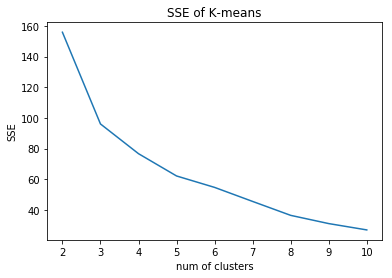

In [163]:
kc = 11
sses = []
majors = []
for k in range(2, kc):
    ndtpb = scale(dtpb.iloc[:, 1:])
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    y_pred = kmeans.fit_predict(ndtpb)
    # clusters = dict.fromkeys([i for i in range(k)],[])
    clusters = dict.fromkeys([i for i in range(k)], None)
    for i in range(len(clusters)):
        clusters[i] = []
    # print("%r rows" %len(y_pred))
    for label in range(len(y_pred)):
        clusters[y_pred[label]].append(label)
    print("k=%r, %r" %(k, calsse(ndtpb, clusters, kmeans.cluster_centers_)))
    sses.append(calsse(ndtpb, clusters, kmeans.cluster_centers_))
    major = {}
    for i in range(k):
        major[i] = [dtpb.iloc[m, 0] for m in clusters.get(i)]
    majors.append(major)
plt.title("SSE of K-means")
plt.xlabel("num of clusters")
plt.ylabel("SSE")
plt.plot(np.arange(2, kc), sses)

k=2, 34584213681.05822
Confusion Matrix:
[[ 9  0  0  0  1  0]
 [ 2  0  0  0  5  0]
 [ 3  0  0  0  1  0]
 [ 1  0  0  0  0  0]
 [ 6  0  0  0 13  0]
 [ 7  0  0  0  2  0]]
The fowlkes_mallows score is 0.40028857644906168
The NMI score is 0.15482102207221524
The purity is 0.44
k=3, 21980561808.00267
Confusion Matrix:
[[ 6  0  0  0  4  0]
 [ 1  0  0  0  6  0]
 [ 3  0  0  0  1  0]
 [ 1  0  0  0  0  0]
 [ 1  0  0  0 18  0]
 [ 3  0  0  0  6  0]]
The fowlkes_mallows score is 0.47519096331149152
The NMI score is 0.22313108387293509
The purity is 0.48
k=4, 16913669969.228239
Confusion Matrix:
[[ 6  1  0  0  3  0]
 [ 1  3  0  0  3  0]
 [ 3  0  0  0  1  0]
 [ 1  0  0  0  0  0]
 [ 1  1  0  0 17  0]
 [ 3  1  0  0  5  0]]
The fowlkes_mallows score is 0.45942824775997393
The NMI score is 0.27741661138097773
The purity is 0.52
k=5, 12756201735.466631
Confusion Matrix:
[[ 9  1  0  0  0  0]
 [ 1  4  0  0  2  0]
 [ 3  0  0  0  1  0]
 [ 1  0  0  0  0  0]
 [ 5  3  0  0 11  0]
 [ 6  3  0  0  0  0]]
The fowlkes

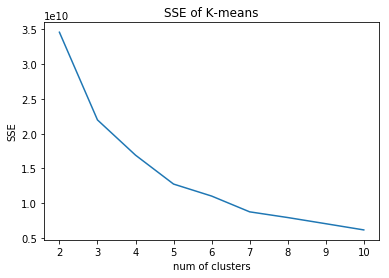

In [303]:
kc = 11
sses = []
majors = []
NMIs = []
for k in range(2, kc):
    ndtpb = dtpb.iloc[:, 1:]
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    y_pred = kmeans.fit_predict(ndtpb)
    # clusters = dict.fromkeys([i for i in range(k)],[])
    clusters = dict.fromkeys([i for i in range(k)], None)
    for i in range(len(clusters)):
        clusters[i] = []
    # print("%r rows" %len(y_pred))
    for label in range(len(y_pred)):
        clusters[y_pred[label]].append(label)
    print("k=%r, %r" %(k, calsse(ndtpb, clusters, kmeans.cluster_centers_)))
    sses.append(calsse(ndtpb, clusters, kmeans.cluster_centers_))
    NMIs.append(matchDomain(y_pred, dtpb_major))
    major = {}
    for i in range(k):
        major[i] = [dtpb.iloc[m, 0] for m in clusters.get(i)]
    majors.append(major)
plt.title("SSE of K-means")
plt.xlabel("num of clusters")
plt.ylabel("SSE")
plt.plot(np.arange(2, kc), sses)

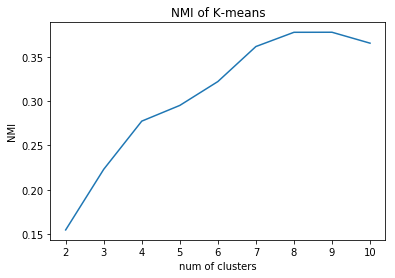

In [304]:
plt.title("NMI of K-means")
plt.xlabel("num of clusters")
plt.ylabel("NMI")
plt.plot(np.arange(2, kc), NMIs)

In [164]:
majors[3]

{0: ['Anthropology',
  'Art History',
  'Biology',
  'Criminal Justice',
  'Drama',
  'Education',
  'English',
  'Forestry',
  'Geography',
  'Graphic Design',
  'Health Care Administration',
  'Hospitality & Tourism',
  'Interior Design',
  'Music',
  'Nutrition',
  'Psychology',
  'Religion',
  'Sociology',
  'Spanish'],
 1: ['Economics', 'Finance', 'Math', 'Physics'],
 2: ['Accounting',
  'Agriculture',
  'Architecture',
  'Business Management',
  'Chemistry',
  'Communications',
  'Film',
  'Geology',
  'History',
  'Information Technology (IT)',
  'International Relations',
  'Journalism',
  'Management Information Systems (MIS)',
  'Marketing',
  'Philosophy',
  'Political Science'],
 3: ['Aerospace Engineering',
  'Chemical Engineering',
  'Civil Engineering',
  'Computer Engineering',
  'Computer Science',
  'Construction',
  'Electrical Engineering',
  'Industrial Engineering',
  'Mechanical Engineering'],
 4: ['Nursing', 'Physician Assistant']}

In [295]:
k = 10
dict_dtpb, y_pred = digdtpb(dtpb, k, nor=True)

k=10, 26.978652743394413
Cluster 0: 'Anthropology, Drama, Forestry, Geography, Graphic Design, Hospitality & Tourism, Music, Psychology, Sociology'
[-0.76725641 -0.94651635 -0.4904833  -0.73579221 -0.85359082 -0.88348796
 -0.54764617]
Cluster 1: 'Civil Engineering, Computer Science, Construction, Industrial Engineering, Mechanical Engineering'
[ 1.2420705   1.12101012 -0.18465976  1.33769178  1.25622618  0.9428578
  0.6903548 ]
Cluster 2: 'Art History, Biology, Communications, English, Film, History, Journalism'
[-0.72100828 -0.47451293  0.53647859 -0.69691188 -0.67112489 -0.28226855
 -0.17286072]
Cluster 3: 'Physician Assistant'
[ 3.23628969  1.06198976 -2.58737994  1.93532655  1.39248889  0.2869397
 -0.68063456]
Cluster 4: 'Economics, Finance, Math, Physics'
[ 0.44405909  1.21581942  1.42279388  0.53383094  0.85432368  1.52290478
  1.76756072]
Cluster 5: 'Criminal Justice, Education, Health Care Administration, Interior Design, Nutrition, Religion, Spanish'
[-0.88441833 -1.26473994 -

In [296]:
y_pred

array([9, 6, 9, 0, 8, 2, 2, 9, 6, 8, 1, 2, 6, 1, 1, 5, 0, 4, 5, 6, 2, 2, 4,
       0, 0, 8, 0, 5, 2, 0, 1, 9, 5, 8, 2, 9, 8, 4, 1, 0, 7, 5, 8, 3, 4, 8,
       0, 5, 0, 5], dtype=int32)

In [305]:
def matchDomain(y_pred, true_label, display=False):
    true_label = np.array(true_label)
    n_cluster = len(set(true_label))
    y_pred_modi = y_pred.copy()
    result = [[] for i in range(len(set(y_pred)))]
    for i in range(len(y_pred)):
        result[y_pred[i]].append(i)
    dict1 = dict.fromkeys([i for i in range(n_cluster)], None)
    for i in list(dict1.keys()):
        dict1[i] = []
    nummostnum = 0
    for i in range(len(result)):
        if len(true_label[result[i]]) > 0:
            mostnum = Counter(true_label[result[i]]).most_common(1)[0][0]
            nummostnum += Counter(true_label[result[i]]).most_common(1)[0][1]
            dict1[mostnum] += (result[i]) 
    for r in list(dict1.keys()):
        for i in dict1[r]:
            y_pred_modi[i] = r
    # calculate the purity

    # return y_pred_modi
    if display:
        print("Confusion Matrix:")
        print(confusion_matrix(true_label, y_pred_modi, [i for i in range(len(set(true_label)))]))
        print("The fowlkes_mallows score is %r"%fowlkes_mallows_score(true_label, y_pred_modi))
        print("The NMI score is %r"%normalized_mutual_info_score(true_label, y_pred))
        print("The purity is %r"%(nummostnum / len(y_pred_modi)))
    
    return normalized_mutual_info_score(true_label, y_pred)

In [302]:
matchDomain(y_pred, dtpb_major)

Confusion Matrix:
[[ 9  0  0  0  1  0]
 [ 2  0  0  0  5  0]
 [ 3  0  0  0  1  0]
 [ 1  0  0  0  0  0]
 [ 6  0  0  0 13  0]
 [ 7  0  0  0  2  0]]
The fowlkes_mallows score is 0.40028857644906168
The NMI score is 0.15482102207221524
The purity is 0.44


0.15482102207221524

In [264]:
k = 6
ndtpbk, ndtpbk_pred = acdigdtpb(dtpb, k, linkage="ward")
matchDomain(ndtpbk_pred, dtpb_major)

Cluster 0: 'Aerospace Engineering, Civil Engineering, Computer Engineering, Computer Science, Electrical Engineering, Mechanical Engineering, Physician Assistant'
Cluster 1: 'Construction, Finance, Industrial Engineering, Marketing, Math, Philosophy, Physics, Political Science'
Cluster 2: 'Criminal Justice, Education, Forestry, Graphic Design, Health Care Administration, Interior Design, Nursing, Nutrition, Religion, Spanish'
Cluster 3: 'Accounting, Agriculture, Architecture, Business Management, Chemistry, Communications, Film, Geology, History, Information Technology (IT), International Relations, Journalism, Management Information Systems (MIS)'
Cluster 4: 'Anthropology, Art History, Biology, Drama, English, Geography, Hospitality & Tourism, Music, Psychology, Sociology'
Cluster 5: 'Chemical Engineering, Economics'
Confusion Matrix:
[[ 4  0  0  0  2  4]
 [ 0  0  0  0  6  1]
 [ 3  0  0  0  1  0]
 [ 1  0  0  0  0  0]
 [ 1  0  0  0 17  1]
 [ 1  0  0  0  4  4]]
The fowlkes_mallows_score

In [256]:
ndtpbk_pred

array([0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 3, 3, 1, 2, 0, 1, 2, 3, 0, 0, 1,
       2, 0, 0, 2, 2, 0, 0, 1, 0, 2, 0, 0, 0, 1, 1, 3, 0, 2, 2, 1, 3, 1, 1,
       0, 2, 0, 2])

For n_clusters = 2 The average silhouette_score is : 0.501390543034


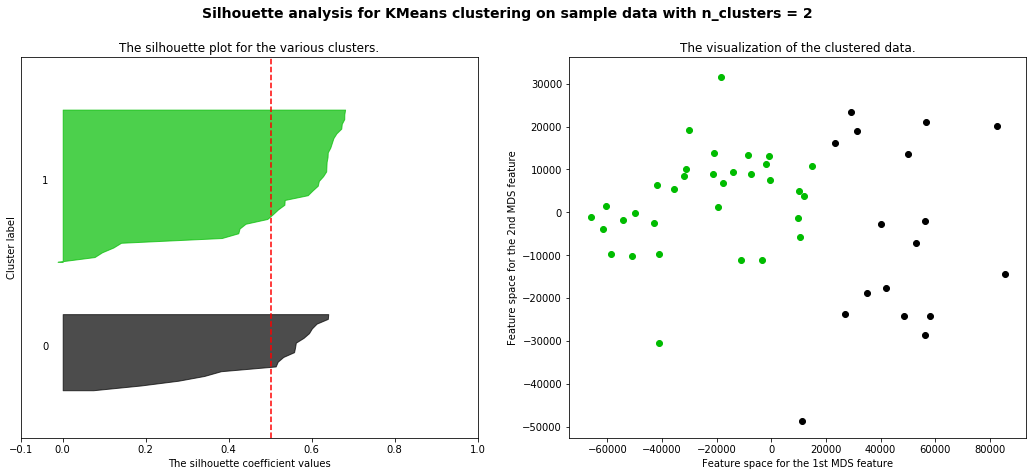

For n_clusters = 3 The average silhouette_score is : 0.412259436089


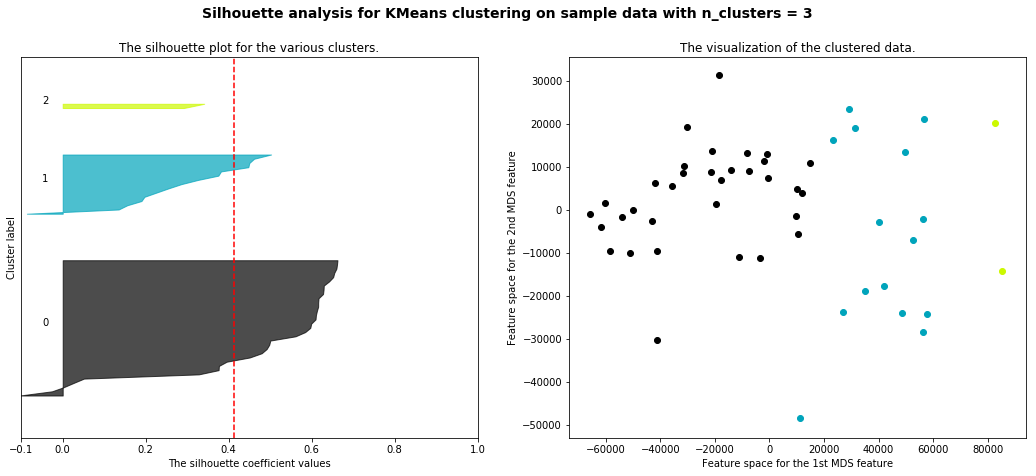

For n_clusters = 4 The average silhouette_score is : 0.363544591148


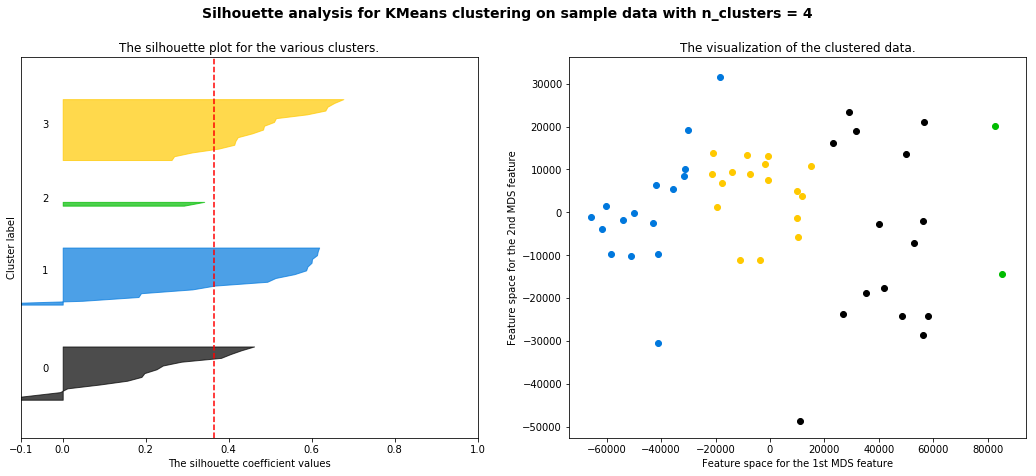

For n_clusters = 5 The average silhouette_score is : 0.388054509104


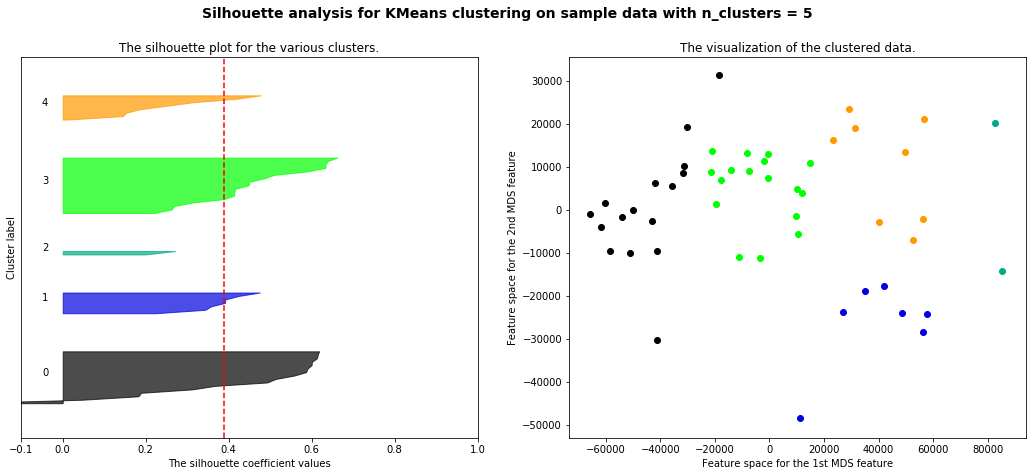

In [181]:
range_n_clusters = [2, 3, 4, 5]
X = dtpb.iloc[:, 1:]
# “euclidean”, “l1”, “l2”, “manhattan”, “cosine”
# “ward”, “complete”, “average”
silhouetteforac(X, range_n_clusters, "manhattan", "complete")

# Try PCA to Plot

In [16]:
from sklearn.decomposition import PCA

In [17]:
pca = PCA(n_components=2)
pca.fit(dtpb.iloc[:, 1:])
print(pca.explained_variance_ratio_) 

[ 0.86069639  0.12155045]


In [18]:
print(np.cumsum(pca.explained_variance_ratio_))

[ 0.86069639  0.98224684]


In [19]:
dtpb_pca = pca.fit_transform(dtpb.iloc[:, 1:])
dtpb_pca = pd.DataFrame(dtpb_pca, columns=["comp1", "comp2"])

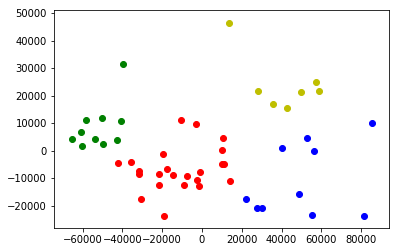

In [20]:
# plt.scatter(plssvd_result[0][index,0],plssvd_result[0][index,1],c="r")
# plt.scatter(plssvd_result[0][index1,0],plssvd_result[0][index1,1],c="b")
# plt.show()
color = ['r', 'b', 'g', 'y']
for i in range(4):
    plt.scatter(dtpb_pca[ndtpbk["cluster"] == i].iloc[:, 0], dtpb_pca[ndtpbk["cluster"] == i].iloc[:, 1], c=color[i])

# MDS Visualization

k=3, 21980561808.00267
Cluster 0: 'Aerospace Engineering, Chemical Engineering, Civil Engineering, Computer Engineering, Computer Science, Construction, Economics, Electrical Engineering, Finance, Industrial Engineering, Marketing, Math, Mechanical Engineering, Philosophy, Physics'
[  5.31133333e+04   9.44400000e+04   7.94000000e+01   5.63133333e+04
   7.22266667e+04   1.28066667e+05   1.73533333e+05]
Cluster 1: 'Art History, Criminal Justice, Education, Forestry, Graphic Design, Health Care Administration, Hospitality & Tourism, Interior Design, Music, Nursing, Nutrition, Psychology, Religion, Sociology, Spanish'
[  3.75800000e+04   5.78600000e+04   5.50866667e+01   3.36200000e+04
   4.32266667e+04   7.93000000e+04   1.10553333e+05]
Cluster 2: 'Accounting, Agriculture, Anthropology, Architecture, Biology, Business Management, Chemistry, Communications, Drama, English, Film, Geography, Geology, History, Information Technology (IT), International Relations, Journalism, Management Inform

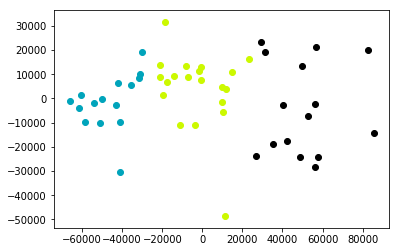

In [152]:
majors, y_pred = digdtpb(dtpb, 3)
mdsvisualization(dtpb.iloc[:, 1:], y_pred, 3)

In [338]:
dtpb.iloc[[1,3,5,7,9], :].mean()#.tolist()

Starting Median Salary                                43180.00
Mid-Career Median Salary                              75880.00
Percent change from Starting to Mid-Career Salary        75.74
Mid-Career 10th Percentile Salary                     42200.00
Mid-Career 25th Percentile Salary                     56400.00
Mid-Career 75th Percentile Salary                    102740.00
Mid-Career 90th Percentile Salary                    143800.00
dtype: float64

Cluster 0: 'Accounting, Aerospace Engineering, Chemistry, Civil Engineering, Computer Engineering, Computer Science, Electrical Engineering, Geology, International Relations, Management Information Systems (MIS), Marketing, Mechanical Engineering, Philosophy, Physician Assistant, Political Science'
Cluster 1: 'Agriculture, Anthropology, Architecture, Art History, Biology, Business Management, Communications, Criminal Justice, Drama, Education, English, Film, Forestry, Geography, Graphic Design, Health Care Administration, History, Hospitality & Tourism, Information Technology (IT), Interior Design, Journalism, Music, Nursing, Nutrition, Psychology, Religion, Sociology, Spanish'
Cluster 2: 'Chemical Engineering, Construction, Economics, Finance, Industrial Engineering, Math, Physics'


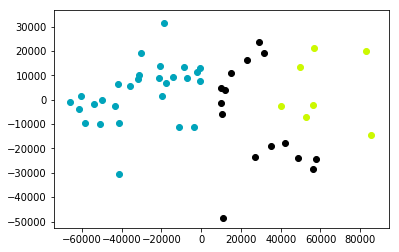

In [153]:
ndtpb, y_pred = acdigdtpb(dtpb, 3)
mdsvisualization(dtpb.iloc[:, 1:], y_pred, 3)

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

For n_clusters = 2 The average silhouette_score is : 0.498912030272


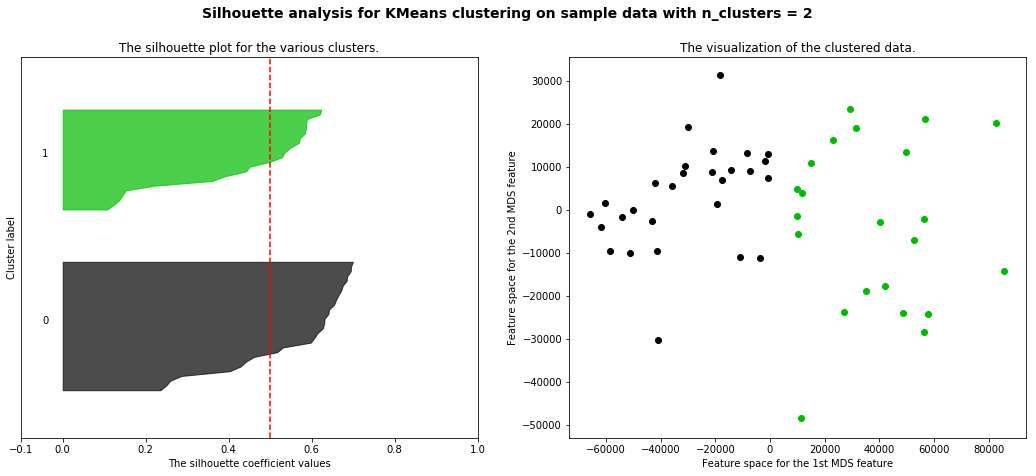

For n_clusters = 3 The average silhouette_score is : 0.426487034384


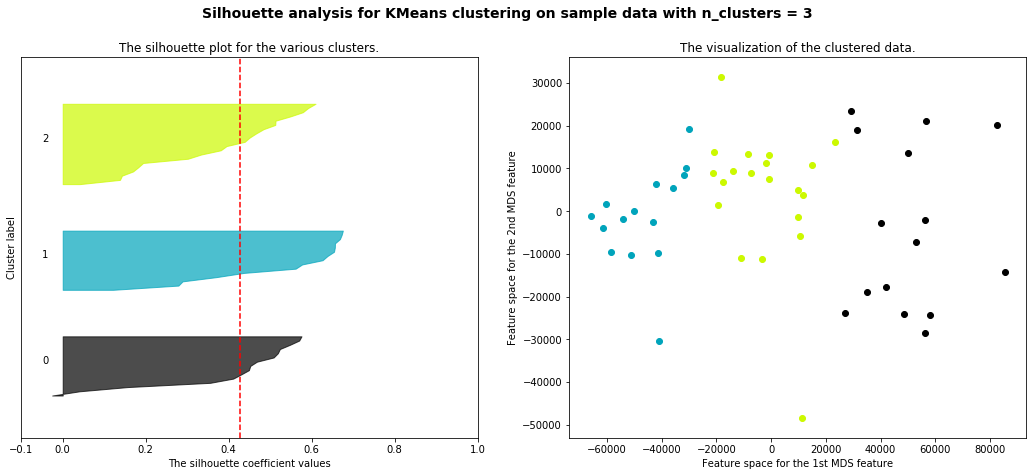

For n_clusters = 4 The average silhouette_score is : 0.412701945984


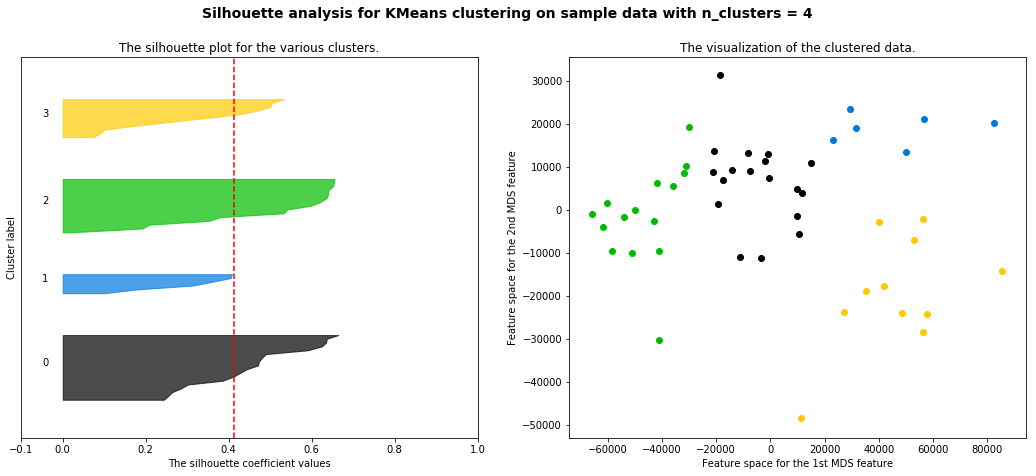

For n_clusters = 5 The average silhouette_score is : 0.377159882763


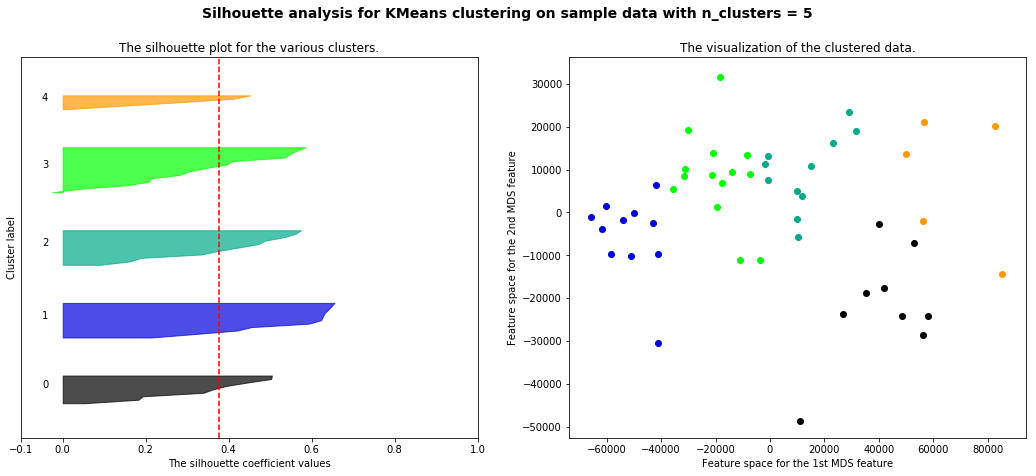

In [173]:
range_n_clusters = [2, 3, 4, 5]
X = dtpb.iloc[:, 1:]
silhouette(X, range_n_clusters)

# DBSCAN

In [48]:
X.dtypes

x1    float64
x2    float64
dtype: object

In [62]:
df = pd.read_table("realdata.txt", header=None, names=["x1", "x2"], index_col=0)
X = StandardScaler().fit_transform(df)

In [63]:
X

array([[-1.82394121, -0.00273794],
       [-1.73471727, -0.23413433],
       [-1.64549334, -0.46553072],
       ..., 
       [ 0.41971503,  0.86858516],
       [ 1.51174192, -0.40120021],
       [ 0.36684985,  0.08370018]])

In [394]:
np.arange(10000, 24000, 2000)

array([10000, 12000, 14000, 16000, 18000, 20000, 22000])

In [392]:
np.arange(10000, 24000, 2000)
a,b,c = dbscandig(df=dtpb, ndf=dtpb.iloc[:, 1:], eps=25000, sc=False)

Cluster 0: 'Accounting, Aerospace Engineering, Agriculture, Anthropology, Architecture, Art History, Biology, Business Management, Chemistry, Civil Engineering, Communications, Computer Engineering, Computer Science, Construction, Criminal Justice, Drama, Education, Electrical Engineering, English, Film, Finance, Forestry, Geography, Geology, Graphic Design, Health Care Administration, History, Hospitality & Tourism, Industrial Engineering, Information Technology (IT), Interior Design, International Relations, Journalism, Management Information Systems (MIS), Marketing, Math, Mechanical Engineering, Music, Nursing, Nutrition, Philosophy, Physics, Political Science, Psychology, Religion, Sociology, Spanish'
Cluster 1: 'Chemical Engineering'
Cluster 2: 'Economics'
Cluster 3: 'Physician Assistant'
SSE is 74530996678.015762


In [357]:
[dtpb.iloc[m, 0] for m in clusters.get(1)]

['Aerospace Engineering',
 'Chemical Engineering',
 'Civil Engineering',
 'Computer Engineering',
 'Computer Science',
 'Construction',
 'Electrical Engineering',
 'Industrial Engineering',
 'Mechanical Engineering']

In [358]:
major

[]

In [76]:
X

array([[  1.82371776e-01,   1.45290546e-01,  -9.44167507e-02,
         -1.01682084e-01,   8.11777824e-03,   2.86939696e-01,
          3.34913113e-01],
       [  1.44494561e+00,   1.64591460e+00,   3.22957177e-01,
          1.75856134e+00,   1.89260201e+00,   1.21697283e+00,
          6.61339149e-01],
       [ -1.84530022e-01,  -1.81205064e-01,  -2.67344921e-02,
         -5.98308155e-01,  -2.81802873e-01,  -2.85764917e-01,
          2.62373994e-01],
       [ -8.10421326e-01,  -8.34196283e-01,  -1.22617692e-01,
         -8.08742932e-01,  -7.60171948e-01,  -6.28408702e-01,
         -1.72860721e-01],
       [ -2.92442316e-01,   1.26454261e-01,   8.64415245e-01,
          6.05378764e-01,   4.50246772e-01,  -2.51500538e-01,
         -2.45399840e-01],
       [ -9.18333619e-01,  -6.20718385e-01,   6.78289034e-01,
         -1.22961248e+00,  -9.99356486e-01,  -7.21412015e-01,
         -6.44364995e-01],
       [ -5.94596738e-01,  -6.26997146e-01,  -1.28257880e-01,
         -5.47803809e-01,  -6.22

## salaries-by-college-type.csv sbct

In [310]:
sbct["School Type"].groupby(sbct["School Type"]).count()

School Type
Engineering      19
Ivy League        8
Liberal Arts     47
Party            20
State           175
Name: School Type, dtype: int64

Engineering-0
Ivy League-1
Liberal Arts-2
Party-3
State-4

In [312]:
sbct_stype = sbct["School Type"].tolist()
for m in range(len(sbct_stype)):
    if sbct_stype[m] == "Engineering":
        sbct_stype[m] = 0
    elif sbct_stype[m] == "Ivy League":
        sbct_stype[m] = 1
    elif sbct_stype[m] == "Liberal Arts":
        sbct_stype[m] = 2
    elif sbct_stype[m] == "Party":
        sbct_stype[m] = 3
    elif sbct_stype[m] == "State":
        sbct_stype[m] = 4

In [333]:
def plotSSENMIKmeans(df, ndf, label_true, sc=False):
    kc = 11
    sses = []
    majors = []
    NMIs = []
    if sc:
        ndf = scale(ndf)
    for k in range(2, kc):
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        y_pred = kmeans.fit_predict(ndf)
        # clusters = dict.fromkeys([i for i in range(k)],[])
        clusters = dict.fromkeys([i for i in range(k)], None)
        for i in range(len(clusters)):
            clusters[i] = []
        # print("%r rows" %len(y_pred))
        for label in range(len(y_pred)):
            clusters[y_pred[label]].append(label)
        print("k=%r, %r" %(k, kmeans.inertia_))
        sses.append(kmeans.inertia_)
        NMIs.append(matchDomain(y_pred, label_true, display=True))
        major = {}
        for i in range(k):
            major[i] = [df.iloc[m, 0] for m in clusters.get(i)]
        majors.append(major)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(9, 4)
    
    
    ax1.set_title("SSE of K-means")
    ax1.set_xlabel("num of clusters")
    ax1.set_ylabel("SSE")
    ax1.plot(np.arange(2, kc), sses)
    
    ax2.set_title("NMI of K-means")
    ax2.set_xlabel("num of clusters")
    ax2.set_ylabel("NMI")
    ax2.plot(np.arange(2, kc), NMIs)
    plt.show()

k=2, 782.85633944770086
Confusion Matrix:
[[  0   0   0   0  19]
 [  0   0   0   0   8]
 [  0   0   0   0  47]
 [  0   0   0   0  20]
 [  0   0   0   0 175]]
The fowlkes_mallows score is 0.68055726192684218
The NMI score is 0.17961927173221776
The purity is 0.6505576208178439
k=3, 536.64270020480899
Confusion Matrix:
[[ 12   0   0   0   7]
 [  8   0   0   0   0]
 [  4   0   0   0  43]
 [  0   0   0   0  20]
 [  4   0   0   0 171]]
The fowlkes_mallows score is 0.71237096240145614
The NMI score is 0.21536366780767238
The purity is 0.6802973977695167
k=4, 417.48772921745461
Confusion Matrix:
[[ 10   0   0   0   9]
 [  8   0   0   0   0]
 [  3   0   0   0  44]
 [  0   0   0   0  20]
 [  1   0   0   0 174]]
The fowlkes_mallows score is 0.72097780562775915
The NMI score is 0.22083128557625784
The purity is 0.6840148698884758
k=5, 357.28021715231233
Confusion Matrix:
[[ 11   0   0   0   8]
 [  1   7   0   0   0]
 [  1   2   0   0  44]
 [  0   0   0   0  20]
 [  2   0   0   0 173]]
The fowlkes

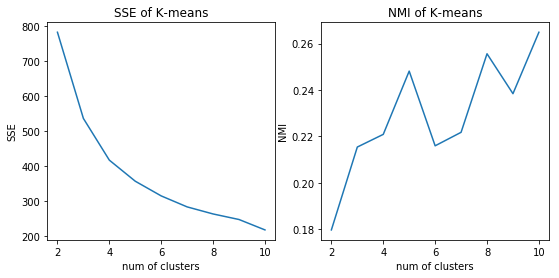

In [335]:
plotSSENMIKmeans(sbct, sbct.iloc[:, 2:], sbct_stype, sc=True)

For n_clusters = 2 The average silhouette_score is : 0.497488112163 The NMI score is :


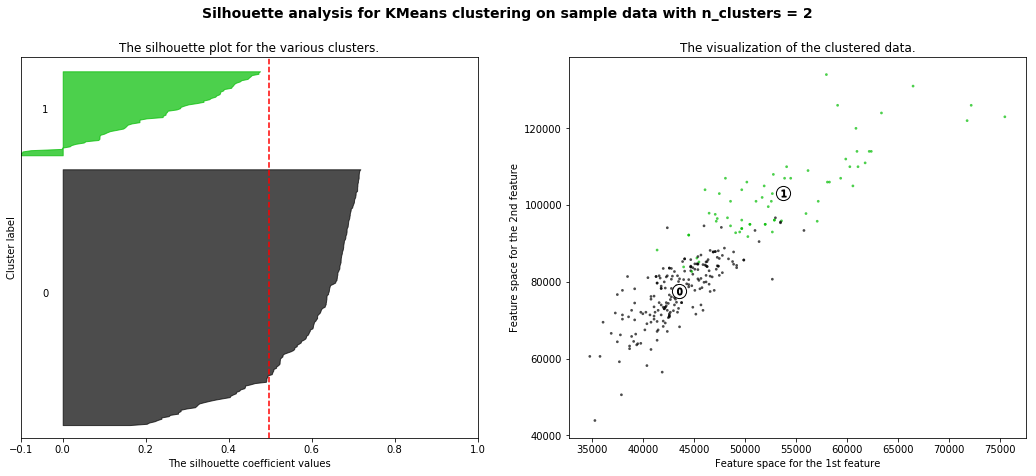

For n_clusters = 3 The average silhouette_score is : 0.408348086949 The NMI score is :


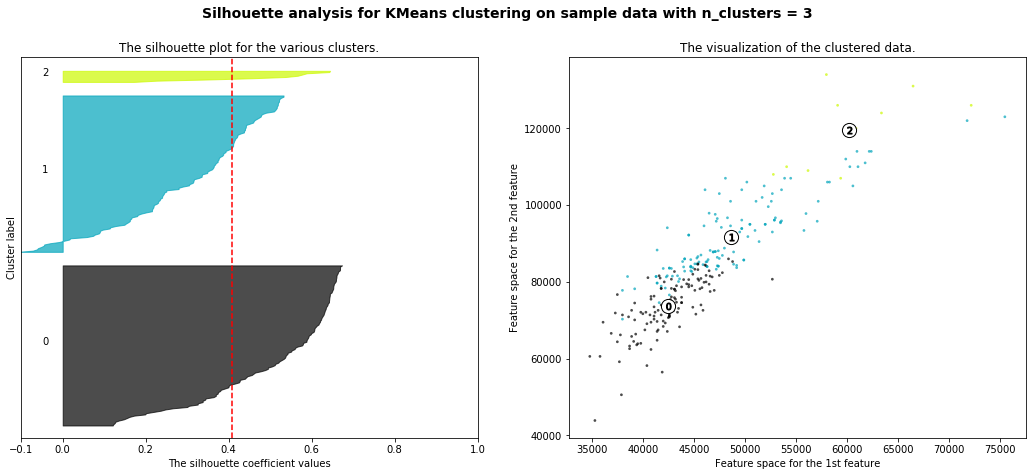

For n_clusters = 4 The average silhouette_score is : 0.391900437304 The NMI score is :


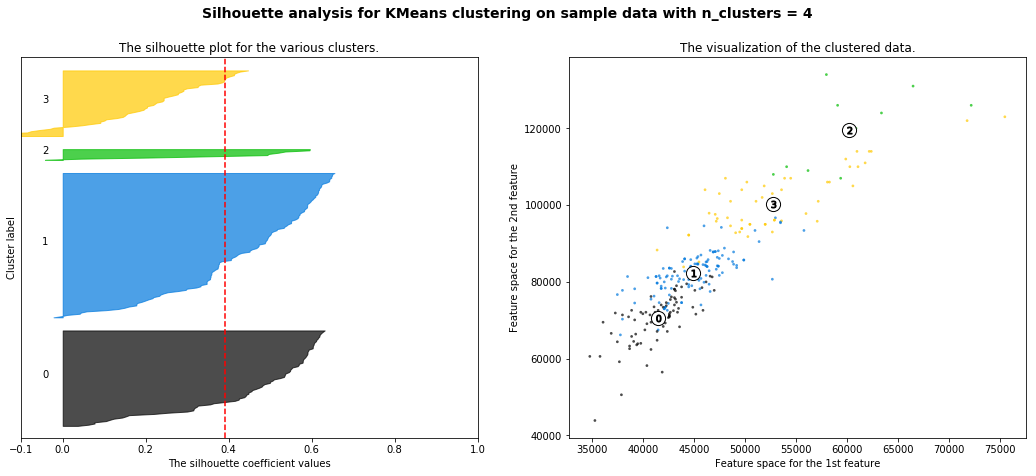

For n_clusters = 5 The average silhouette_score is : 0.379425610402 The NMI score is :


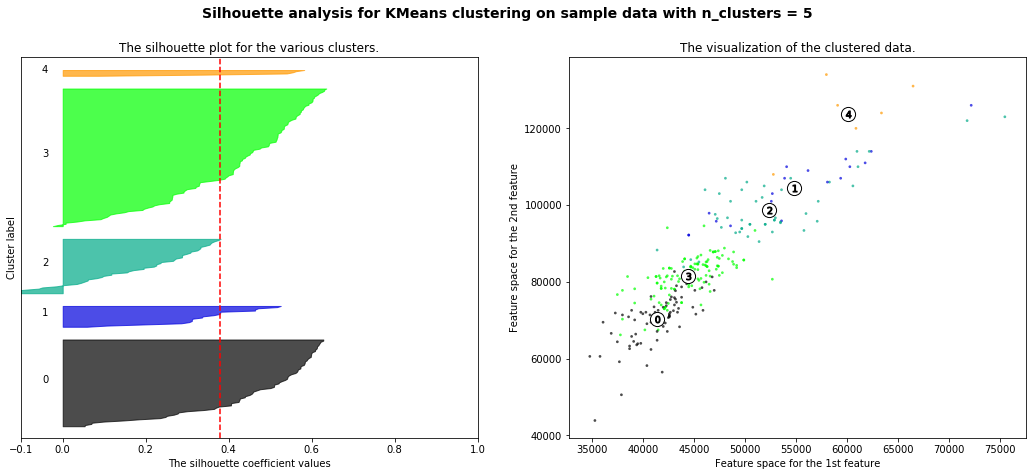

For n_clusters = 6 The average silhouette_score is : 0.33679790136 The NMI score is :


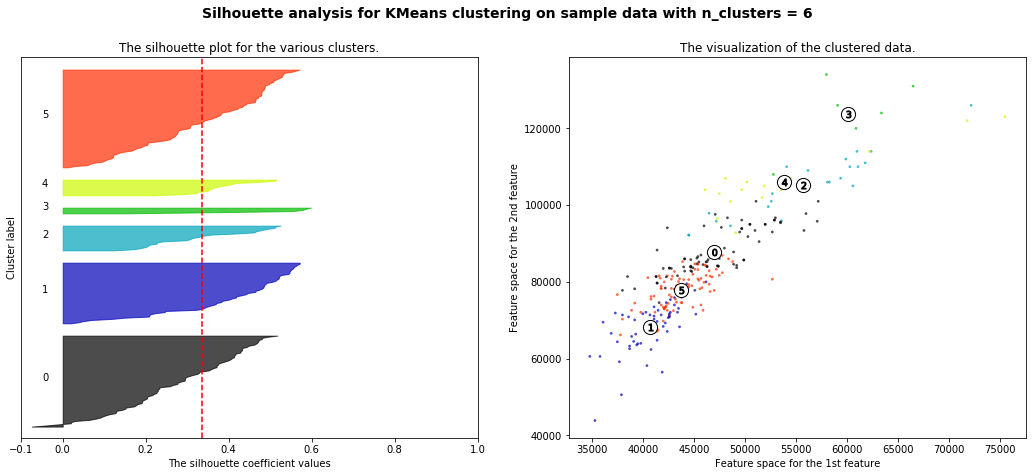

For n_clusters = 7 The average silhouette_score is : 0.305328004264 The NMI score is :


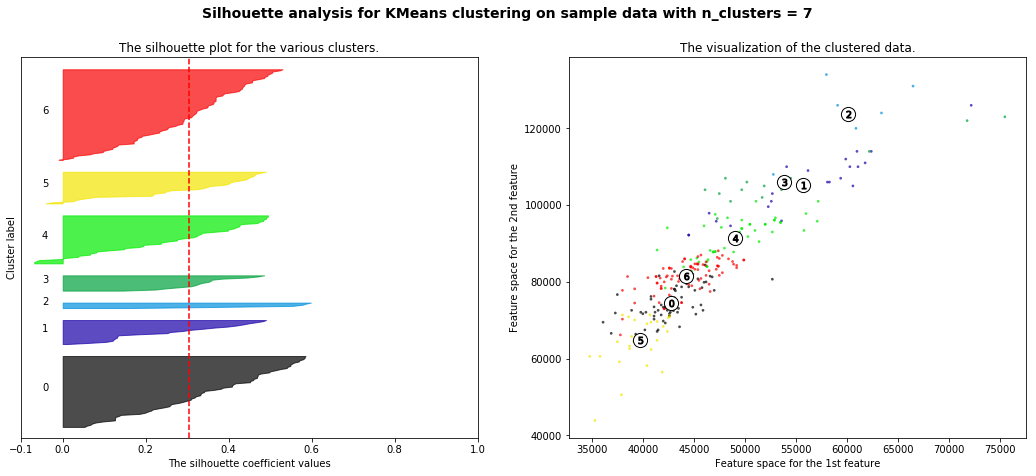

For n_clusters = 8 The average silhouette_score is : 0.310635061202 The NMI score is :


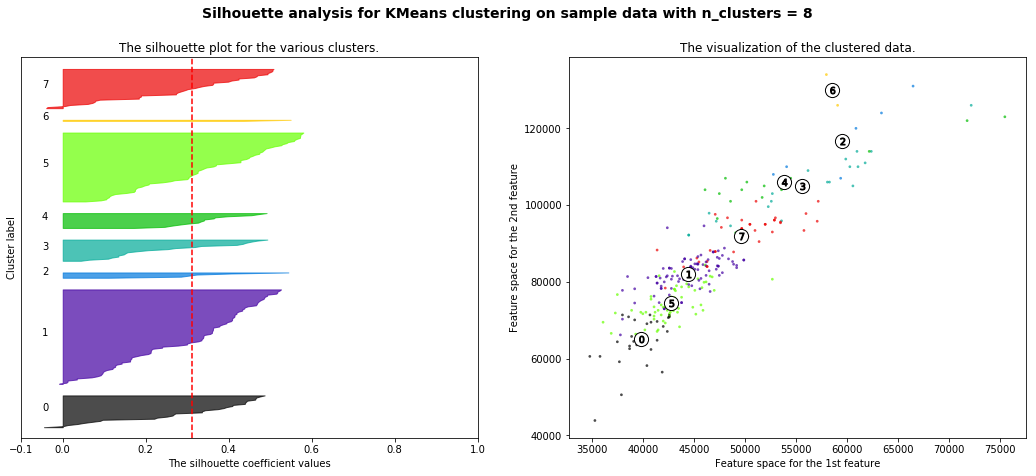

In [28]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
X = sbct.iloc[:, 2:]
silhouette(X, range_n_clusters)

For n_clusters = 2 The average silhouette_score is : 0.67675797858


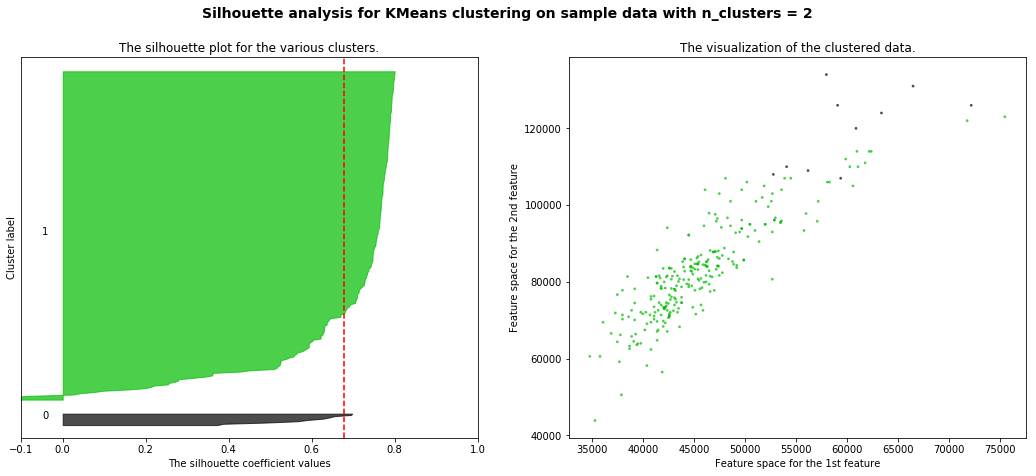

For n_clusters = 3 The average silhouette_score is : 0.629263465122


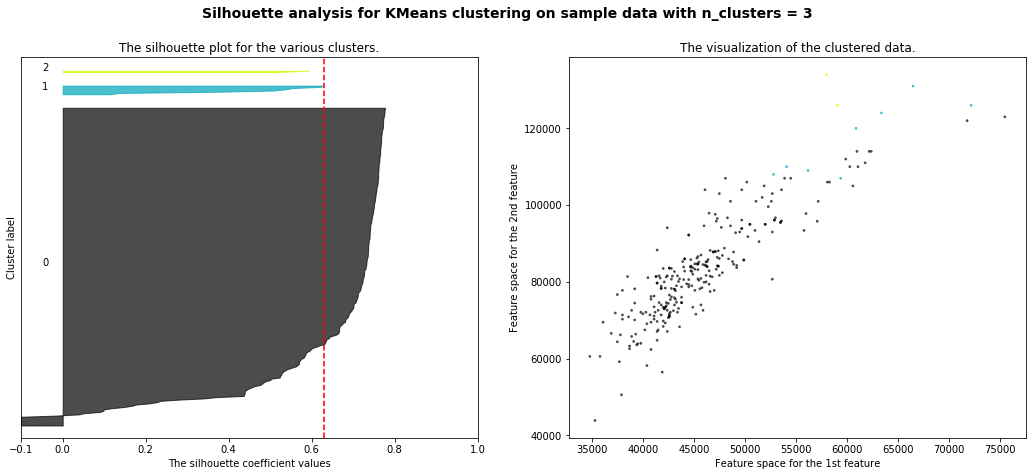

For n_clusters = 4 The average silhouette_score is : 0.409642598733


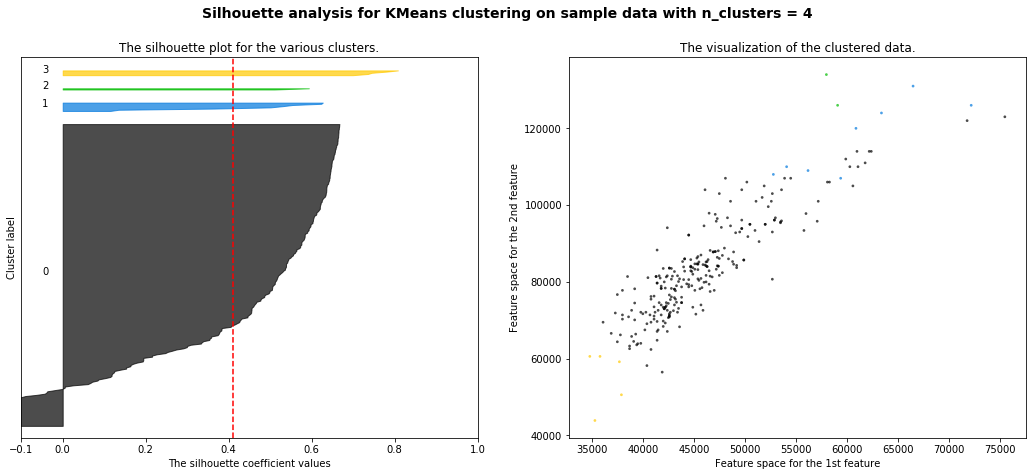

For n_clusters = 5 The average silhouette_score is : 0.369593778779


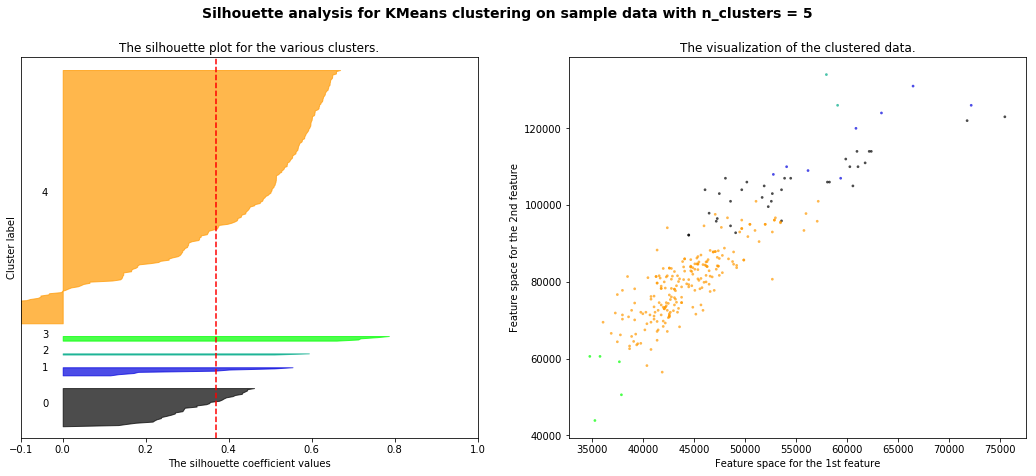

In [31]:
range_n_clusters = [2, 3, 4, 5]
X = sbct.iloc[:, 2:]
silhouetteforac(X, range_n_clusters, "euclidean", "average")

In [8]:
dtpb.iloc[:, 1:]

,Starting Median Salary,Mid-Career Median Salary,Percent change from Starting to Mid-Career Salary,Mid-Career 10th Percentile Salary,Mid-Career 25th Percentile Salary,Mid-Career 75th Percentile Salary,Mid-Career 90th Percentile Salary
0,46000.0,77100.0,67.6,42200.0,56100.0,108000.0,152000.0
1,57700.0,101000.0,75.0,64300.0,82100.0,127000.0,161000.0
2,42600.0,71900.0,68.8,36300.0,52100.0,96300.0,150000.0
3,36800.0,61500.0,67.1,33800.0,45500.0,89300.0,138000.0
4,41600.0,76800.0,84.6,50600.0,62200.0,97000.0,136000.0
5,35800.0,64900.0,81.3,28800.0,42200.0,87400.0,125000.0
6,38800.0,64800.0,67.0,36900.0,47400.0,94500.0,135000.0
7,43000.0,72100.0,67.7,38800.0,51500.0,102000.0,147000.0
8,63200.0,107000.0,69.3,71900.0,87300.0,143000.0,194000.0
9,42600.0,79900.0,87.6,45300.0,60700.0,108000.0,148000.0


array([10,  2,  3,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  6,  5,  5,  5,  5,  8,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  4,  5,  5,  5,  5,  5,  5,  5,  4,  5,  5,  5,  5,
        5, 11,  9, 12,  1,  1,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5

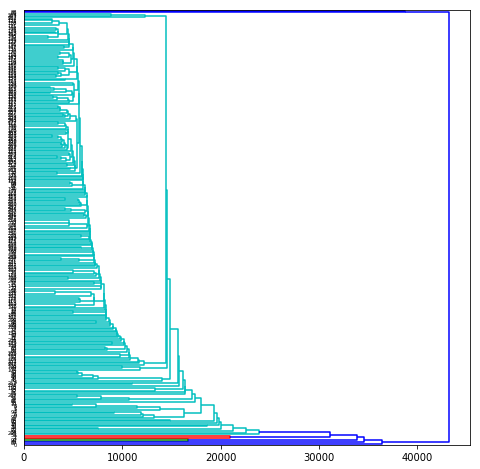

In [22]:
def externalEval(y_pred, true_label):
    true_label = np.array(true_label)
    n_cluster = len(set(true_label))
    y_pred_modi = y_pred.copy()
    result = [[] for i in set(y_pred)]
    for i in range(len(y_pred)):
        result[y_pred[i]].append(i)
    dict1 = dict.fromkeys([i for i in range(n_cluster)], None)
    for i in list(dict1.keys()):
        dict1[i] = []
    nummostnum = 0
    for i in range(len(result)):
        if len(true_label[result[i]]) > 0:
            mostnum = Counter(true_label[result[i]]).most_common(1)[0][0]
            nummostnum += Counter(true_label[result[i]]).most_common(1)[0][1]
            dict1[mostnum] += (result[i])
    for r in list(dict1.keys()):
        for i in dict1[r]:
            y_pred_modi[i] = r
    nmi = normalized_mutual_info_score(true_label, y_pred)
    purity = nummostnum / len(y_pred_modi)
    fowlkes_mallows = fowlkes_mallows_score(true_label, y_pred_modi)
    return nmi, purity, fowlkes_mallows

In [24]:
#externalEval(clusters, sbct.iloc[:, 1].tolist())
from sklearn.metrics import homogeneity_score

In [26]:
clusters

array([10,  2,  3,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  6,  5,  5,  5,  5,  8,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  4,  5,  5,  5,  5,  5,  5,  5,  4,  5,  5,  5,  5,
        5, 11,  9, 12,  1,  1,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5

In [42]:
from scipy.cluster.hierarchy import dendrogram, fcluster
import pylab
fig = pylab.figure(figsize=(8,8))
Y = sch.linkage(sbct.iloc[:, 2:], method='single', metric = 'euclidean', )
Z = dendrogram(Y, orientation='right')
clusters = fcluster(Y, 20000, criterion = "distance", depth = 3)

y_pred = clusters
true_label = np.array(["a", 'b',"a", 'a',"a", 'a',"a", 'b'])

In [43]:
result = [[] for i in set(y_pred)]
for i in range(len(y_pred)):
    result[y_pred[i]].append(i)
nummostnum = 0
for i in range(len(result)):
    nummostnum += Counter(true_label[result[i]]).most_common(1)[0][1]
purity = nummostnum / len(y_pred)
purity

0.75